# CmdStanPy Tutorial


### Workflow Outline

Given a dataset and a model specification written as a Stan program, the CmdStanPy workflow is:

#### Assemble input data as either:
  + A Python `dict` object consisting of key-value pairs where the key corresponds
 to Stan data variables and the value is of the correct type and shape.
  + An existing data file on disk in either JSON or Rdump format.

#### Compile the model
  + A `Model` object stores the filepath of the Stan program.
  + Method `compile` translates the Stan program to C++ then calls the C++ compiler.

#### Fit the model using the data,  sample from the posterior
  + The `Model` class method `sample` invokes Stan's NUTS-HMC sampler to condition model on input data and returns a `StanFit` object which contains a set of draws from the posterior plus metadata.
  + Runs any number of chains - default is 4 chains.
  + The output of each chain is stored on disk as a Stan csv file.

#### Summarize and check the fit
   + The `StanFit` class method `summary` invokes CmdStan's `stansummary` utility. Returns a Pandas DataFrame with estimates of posterior means, standard deviations, Monte-Carlo standard error, effective sample size, and convergence diagnostic statistic for all parameters in the model.
   + The `StanFit` class method `diagnose` invokes CmdStan's `diagnose` utility which checks for the following problems:
    + transitions that hit the maximum treedepth
    + divergent transitions
    + low E-BFMI values (sampler transitions HMC potential energy)
    + low effective sample sizes
    + high R-hat values

####  Assemble the sample in-memory
  + The resulting sample is accessed via the `StanFit` object:
    + `sample`  - all draws from all chains, stored as a 3-D numpy.ndarray.
    + `chains` - number of chains run by sampler
    + `draws` - draws per chain
    + `column_names` - names of the parameters, transformed parameters, and generated quantities variables returned in each draw
    + `csv_files` - list of Stan csv output files which comprise the sample
  + The method `get_drawset` flattens the 3-D sample array into a 2-D pandas.DataFrame for downstream analysis.


### Installation

* Install Python package from PyPI or directly from GitHub:

  + `pip install --upgrade cmdstanpy`
  + `pip install -e git+https://github.com/stan-dev/cmdstanpy`


* CmdStanPy uses CmdStan directly to compile and run Stan programs, therefore CmdStan must be installed locally.

  + if you have a working installation of CmdStan, set environment variable `CMDSTAN` to the full path to the top-level CmdStan directory.
  
  + if you don't already have CmdStan installed, run Python script `install_cmdstan` which downloads and compiles the latest release from https://github.com/stan-dev/cmdstan/releases.  By default this installs the latest version of CmdStan in the location `~/.cmdstanpy`.  Flags -d and -v are used to specify the directory and version, respectively.


### Example 1:  Compile and run CmdStan example model `bernoulli.stan`, data `bernoulli.data.json`

Every CmdStan release has an `examples/bernoulli` directory which contains the Stan model and test data files.  In this example we compile the model and run the sampler on the model and data.

#### Import relevant classes and methods

In [1]:
import os
import os.path
from cmdstanpy import Model, StanFit, cmdstan_path

#### Compile the model

The CmdStanPy directory `examples/bernoulli` contains the model and data files.

In [2]:
bernoulli_path = os.path.join(cmdstan_path(), 'examples', 'bernoulli', 'bernoulli.stan')

First we create a `Model` object for the specified Stan program file, then we call the `compile` method to create the corresponding C++ executable program.

In [3]:
bernoulli_model = Model(stan_file=bernoulli_path)
bernoulli_model.compile()
print(bernoulli_model)

INFO:cmdstanpy:compiling c++
INFO:cmdstanpy:compiled model file: /Users/lauren.valdivia/.cmdstanpy/cmdstan-2.19.1/examples/bernoulli/bernoulli


Model(name=bernoulli,  stan_file="/Users/lauren.valdivia/.cmdstanpy/cmdstan-2.19.1/examples/bernoulli/bernoulli.stan", exe_file="/Users/lauren.valdivia/.cmdstanpy/cmdstan-2.19.1/examples/bernoulli/bernoulli")


#### Run the HMC-NUTS sampler on the model and data

Input data is either a Python `Dict` with entries corresponding to input data values, or it can be a file in JSON or Rdump format.

In [4]:
bern_json = os.path.join(bernoulli_path, 'bernoulli.data.json')

If a `Dict` is specified, CmdStanPy writes it to a temp file in JSON format.

In [5]:
bern_data = { "N" : 10, "y" : [0,1,0,0,0,0,0,0,0,1] }

The `Model` method `sample` runs the NUTS-HMC sampler and returns a `StanFit` object.

In [6]:
bern_fit = bernoulli_model.sample(data=bern_data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2


By default, `sample` runs 4 sampler chains.  The `chains` argument specifies the number of chains to run.  The `cores` argument specifies the number of processes to run in parallel.

In [7]:
bern_fit = bernoulli_model.sample(chains=5, cores=3, data=bern_data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 5
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 5


#### Access the sample: the `StanFit` object attributes and methods

##### Summarize the results

The `StanFit` method `summary` returns output of CmdStan bin/stansummary as pandas.DataFrame:

In [8]:
bern_fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-7.274580,0.015346,0.725103,-8.729040,-6.993690,-6.749990,2232.51,14605.0,1.00112
theta,0.251214,0.002739,0.120618,0.079431,0.238581,0.474282,1939.92,12690.9,1.00130


##### Run sampler diagnostics

The `StanFit` method `diagnose` prints diagnostics to console:

In [9]:
bern_fit.diagnose()

##### Get all draws from all chains as an in-memory pandas DataFrame

The `StanFit` method `get_drawset` returns a pandas.DataFrame, one draw per row.

In [10]:
bern_drawset = bern_fit.get_drawset()

By default, `get_drawset` returns a DataFrame which contains all columns from the sampler's csv output file, i.e., it contains both the sampler state and the values for all parameter, transformed parameter, and generated quantities variables.

In [11]:
bern_drawset.shape, bern_drawset.columns

((5000, 8),
 Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
        'divergent__', 'energy__', 'theta'],
       dtype='object'))

The `get_drawset` function argument `params` takes a list of parameter or column names:

In [12]:
thetas = bern_fit.get_drawset(params=['theta'])
thetas.shape


(5000, 1)

In [13]:
thetas[0:3]

,theta
0,0.342321
1,0.443100
2,0.189670


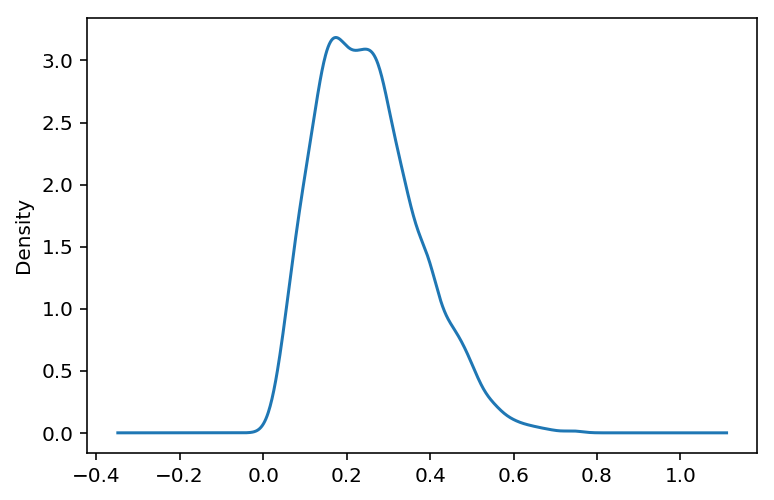

In [14]:
bern_drawset.theta.plot.density()

The `StanFit` property `sample` is a 3-D numpy ndarray which contains all draws across all chains.  This array is created only as needed; therefore the first time that this property is accessed CmdStanPy will read in the contents of the sampler's csv output files.  Because the csv output files also contain stepsize and metric information, the `stepsize` and `metric` arrays will also be created.

The numpy ndarray is stored column major format so that values for each parameter are stored contiguously in memory, likewise all draws from a chain are contiguous.  Thus the dimensions of the ndarray are arranged as follows:  (draws, chains, columns):

In [15]:
bern_fit.sample
bern_fit.sample.shape

array([[[-6.98736  ,  1.       ,  0.860234 , ...,  0.       ,
          7.2668   ,  0.342321 ],
        [-6.7971   ,  1.       ,  0.954811 , ...,  0.       ,
          6.82357  ,  0.212266 ],
        [-7.21364  ,  1.       ,  1.11266  , ...,  0.       ,
          8.00017  ,  0.381288 ],
        [-6.88119  ,  1.       ,  1.14001  , ...,  0.       ,
          7.15379  ,  0.189466 ],
        [-7.72439  ,  0.999538 ,  1.02057  , ...,  0.       ,
          8.07603  ,  0.444605 ]],

       [[-7.7102   ,  0.813175 ,  0.860234 , ...,  0.       ,
          7.71294  ,  0.4431   ],
        [-6.84176  ,  0.987872 ,  0.954811 , ...,  0.       ,
          6.84871  ,  0.198646 ],
        [-7.07381  ,  1.       ,  1.11266  , ...,  0.       ,
          7.25283  ,  0.358643 ],
        [-6.79461  ,  1.       ,  1.14001  , ...,  0.       ,
          6.8601   ,  0.213197 ],
        [-7.19766  ,  1.       ,  1.02057  , ...,  0.       ,
          7.63383  ,  0.378876 ]],

       [[-6.88023  ,  0.907623 ,  0.

(1000, 5, 8)

Python's index slicing operations can be used to access the information by chain.
For example, to select all draws and all output columns from the first chain,
we specify the chain index (2nd index dimension).  As arrays indexing starts at 0,
the index '0' corresponds to the first chain in the ``RunSet``.

The following expression selects the first 3 draws from chain 1 for the parameter `theta`:

In [16]:
bern_fit.column_names[7], bern_fit.sample[0:3,0,7]

('theta', array([0.342321, 0.4431  , 0.18967 ]))

#### stepsize

The `StanFit` property `stepsize` property is a 1-D numpy ndarray which contains the stepsize used by the sampler for each chain.  This array is created at the same time as the `sample` and `metric` arrays are created.

At the end of adaptation, the stepsize for the 4 chains in this example is:

In [17]:
bern_fit.stepsize

array([0.860234, 0.954811, 1.11266 , 1.14001 , 1.02057 ])

#### metric_type, metric

The `metric` property is an numpy ndarray which contains the metric used by the sampler for each chain.  This array is created at the same time as the `sample` and `stepsize` arrays are created.

At the end of adaptation, the metric for the 4 chains in this example is:

In [18]:
bern_fit.metric_type,  bern_fit.metric

('diag_e', array([[0.549992],
        [0.610039],
        [0.403894],
        [0.454962],
        [0.496115]]))

### Example 2:  Compile and run CmdStan example model `bernoulli_ppc.stan`, data `bernoulli.data.json` and execute generate_quantities method

The `bernoulli_ppc` directory contains the Stan model and the results of a fitted bernoulli sampler.  In this example we execute the `generated quantities` block using previously fitted parameters from a bernoulli sampler.  The `generated quantities` method can be used to generate additional quantities of interest conditioned on the data.  For example, `generated quantities` can be used for generating predictions for new data, calculating posterior event probabilities,  transforming parameters for reporting, etc.

The data paths below will work if run from the parent cmdstanpy directory.

In [31]:
CWD = os.getcwd()
test_data_path = os.path.join(CWD, 'test', 'data')
bernoulli_ppc_path = os.path.join(test_data_path, 'bernoulli_ppc')
bernoulli_ppc_model = os.path.join(bernoulli_ppc_path,'bernoulli_ppc.stan')
sampling_output_file = os.path.join(bernoulli_ppc_path,'sampling_output.csv')

First we create a Model object for the specified Stan program file, which contains a `generated quantities` block, then we call the compile method to create the corresponding C++ executable program.

`
generated quantities {
  real mu = theta;
  int y_rep[N];
  for (n in 1:N)
    y_rep[n] = bernoulli_rng(theta);
}`

In [ ]:
bern_gq_model = Model(stan_file=stan_file)
bern_gq_model.compile()
print(bern_gq_model)

The `run_generate_quantities` method executes the `generated quantities` block in the stan model using the fitted parameters provided in `fitted_params_file`.  The data used to fit the model should be specified as `data`.  The `run_generate_quantities` returns a `StanFit` object.

In [29]:
stanfit_gq = bern_gq_model.run_generate_quantities(fitted_params_file=sampling_output_file,data = bern_json)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


The `StanFit` property `generated_quantities` returns a numpy ndarray of the result.

In [30]:
stanfit_gq.generated_quantities

array([[0.170975 , 1.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.278471 , 0.       , 0.       , ..., 1.       , 1.       ,
        0.       ],
       [0.0961425, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.310705 , 0.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       [0.273562 , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.388814 , 1.       , 0.       , ..., 0.       , 0.       ,
        1.       ]])